In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress as ip
import tldextract
import pickle as pkl
import sklearn.ensemble as ensembleLearning
import sklearn
import re

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn import linear_model
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from urllib.parse import urlparse
from __future__ import division
from scipy import stats
from sklearn_pandas import DataFrameMapper

In [2]:
# Original Dataset with Domain + Label with other features value
data = pd.read_csv('DataSet/PhishLegitimateDataSet.csv')
# data.head()
# Get domain and label only : 1st way
header = ['domain', 'label']
# Export to new CSV
data.to_csv('DataSet/PhishLegitimateDataSet_Cleaned1.csv', columns = header, index = False)

# Get domain and label only : 2nd way
dfRequired = data[['domain', 'label']]
# Export to new CSV
dfRequired.to_csv('DataSet/PhishLegitimateDataSet_Cleaned2.csv', index = False)
dfRequired.head()

,domain,label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1.0
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1.0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1.0
3,mail.printakid.com/www.online.americanexpress....,1.0
4,thewhiskeydregs.com/wp-content/themes/widescre...,1.0


In [3]:
# Helper Functions
def get_f1_score(Y_test, Y_predict, title):
    test_size = len(Y_test)
    score = 0
    
    for i in range(test_size):
        if Y_predict[i] == Y_test[i]:
            score += 1
            
    print('Got %s out of %s' % (score, test_size))
    print('f1 = %.2f' % (f1_score(Y_test, Y_predict, average = 'binary')))
    print('precision = %.2f' % (precision_score(Y_test, Y_predict, average = 'binary')))
    print('recall = %.2f' % (recall_score(Y_test, Y_predict, average = 'binary')))
    print('accuracy = %.2f' % (accuracy_score(Y_test, Y_predict)))

    bar_width = 0.20
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    index = np.arange(1)

    fig, ax = plt.subplots()

    ax.bar(index, f1_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'b',
           error_kw = error_config,
           label = 'F Score')
    ax.bar(index + bar_width * 1, precision_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'r',
           error_kw = error_config,
           label = 'Precision')
    ax.bar(index + bar_width * 2, recall_score(Y_test, Y_predict, average = 'binary'), bar_width,
           alpha = opacity, color = 'g',
           error_kw = error_config,
           label = 'Recall')
    ax.bar(index + bar_width * 3, accuracy_score(Y_test, Y_predict), bar_width,
           alpha = opacity, color = 'y',
           error_kw = error_config,
           label = 'Accuracy')
    ax.set_xlabel('Measures')
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.tick_params(
        axis = 'x',           # changes apply to the x-axis
        which = 'both',       # both major and minor ticks are affected
        bottom = False,       # ticks along the bottom edge are off
        top = False,          # ticks along the top edge are off
        labelbottom = False)  # labels along the bottom edge are off
    ax.legend()
    fig.tight_layout()
    plt.show()
    
def show_scores_bar(results, models):
    bar_width = 0.20
    opacity = 0.4
    error_config = {'ecolor': '0.3'}
    index = np.arange(1)

    fig, ax = plt.subplots()
    
    bar_colors = ['b', 'r', 'g', 'y', 'c', 'm', 'k']
    i = 0
    
    for algo in models:
        ax.bar(index + bar_width * i, results[algo], bar_width, alpha = opacity, 
               color = bar_colors[i], error_kw = error_config, label = algo)
        i += 1
    
    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Score of different Classifiers')
    ax.tick_params(
        axis = 'x',           # changes apply to the x-axis
        which = 'both',       # both major and minor ticks are affected
        bottom = False,       # ticks along the bottom edge are off
        top = False,          # ticks along the top edge are off
        labelbottom = False)  # labels along the bottom edge are off
    ax.legend()
    fig.tight_layout()
    plt.show()
    
# we use this function when feature vector has label (binary) at end, 
# and use it in conjuction with def make_np_array_XY(xy):
def make_feature_vector(from_index, url, label):
    feature_vector = []
    for i in range(len(url)):
        s = url[from_index + i]
        if len(s) > 0:
            feature = getFeatures(url[from_index + i], label[from_index + i])
        feature_vector.append(feature)
    return feature_vector

def make_np_array_XY(xy):
    a = np.array(xy)
    x = a[:, 0:-1]
    y = a[:, -1]
    return x, y

def get_length(str):
    return len(str)

def get_forward_slash_count(str):
    return str.count('/')

def get_dot_count(str):
    return str.count('.')

def getTokens(input):
    tokensBySlash = str(input.encode('utf-8')).split('/')
    allTokens = []
    
    for i in tokensBySlash:
        tokens = str(i).split('-')
        tokensByDot = []
        for j in range(0,len(tokens)):
            tempTokens = str(tokens[j]).split('.')
            tokensByDot = tokensByDot + tempTokens
        allTokens = allTokens + tokens + tokensByDot
        
    allTokens = list(set(allTokens))
    
    if 'com' in allTokens:
        allTokens.remove('com')
        
    return allTokens

def get_url_scheme(url):
    parse_object = urlparse(url)
    return parse_object.scheme

def get_domain_from_url(url):
    return url[:url.find('/',8)]

def get_path_from_url(url):
    return url[url.find('/',8):]

def getTokens1(url):
    return re.split('\W+', url)

In [4]:
# Syntatic and Reputation based
def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0

def scheme_http_or_not(url):
    if get_url_scheme(url) == 'http' or get_url_scheme(url) == 'https':
        return 1
    return 0

def is_https(url):
    if get_url_scheme(url) == 'http' or get_url_scheme(url) == 'https':
        if get_url_scheme(url) == 'https':
            return 1
        else:
            return 0
    else:
        return 0
    
def is_exe(url):
    if ".exe" in url:
        return 1 
    else:
        return 0 
    
def is_short_url(url):
    if ".ly" in url:
        return 1
    else:
        return 0
    
def suspicious_word_count(url):
    tokens_words = getTokens1(url)
    sec_sen_words = ['confirm',
                     'signon',
                     'account',
                     'banking',
                     'secure',
                     'ebayisapi',
                     'webscr',
                     'login',
                     'signin',
                     'recovery',
                     'forgotpassword']
    cnt = 0
    for ele in sec_sen_words:
        if(ele in tokens_words):
            cnt += 1
    return cnt

def Presence_of_IP(url):
    tokens_words = getTokens1(url)
    cnt = 0

    for ele in tokens_words:
        try:
            ele = unicode(ele, "utf-8")
            ip = ipaddress.ip_address(ele)
            cnt += 1
        except:
            pass
    
    if cnt > 0:
        return 1
    
    return 0

def token_count(url):
    return len(getTokens1(url))

def has_port_number(url):
    url_port = urlparse(url)
    
    if url_port.port != None:
        return 1
    
    return 0

# LEXICAL FEATURES
# URL Related
def alphabet_count(url):
    return sum(url_char.isalpha() for url_char in url)

def digit_count(url):
    return sum(url_char.isdigit() for url_char in url)

def get_at_count(str):
    return str.count('@')
    
def get_hyphen_count(str):
    return str.count('-')

def get_amp_count(str):
    return str.count('&')

def get_delimeter_count(str):
    count = 0
    delim = [';', '_', '?', '=', '&']
    delim = ['-',
             '.',
             '_',
             '~',
             ':',
             '/',
             '?',
             '#',
             '[',
             ']',
             '@',
             '!',
             '$',
             '&',
             '\'',
             '(',
             ')',
             '*',
             '+',
             ',',
             ';',
             '=',
             '`',
             '.']
    for each in str:
        if each in delim:
            count = count + 1
    return count

def get_forward_slash_count_in_url(url):
    return get_forward_slash_count(url)

def get_dot_count_in_url(url):
    return get_dot_count(url)

def get_url_length(url):
    return get_length(url)

# Domain Related
def get_forward_slash_count_in_domain(url):
    return get_forward_slash_count(get_domain_from_url(url))

def get_dot_count_in_domain(url):
    return get_dot_count(get_domain_from_url(url))

def get_domain_length(url):
    return get_length(get_domain_from_url(url))

# Path Related
def get_forward_slash_count_in_path(url):
    return get_forward_slash_count(get_path_from_url(url))

def get_dot_count_in_path(url):
    return get_dot_count(get_path_from_url(url))

def get_path_length(url):
    return get_length(get_path_from_url(url))

In [5]:
def getFeatures(url, label): 
    s = str(url)
    path = urlparse(s)
    ext = tldextract.extract(s)
    feature = []
    #Semantic
    feature.append(isip(ext.domain))
    feature.append(len(path.query)) # number of queries
    feature.append(scheme_http_or_not(s))
    feature.append(is_https(path.netloc))
    feature.append(is_exe(s))
    feature.append(is_short_url(s))
    feature.append(suspicious_word_count(s))
    feature.append(Presence_of_IP(s))
    feature.append(token_count(s))
    feature.append(has_port_number(s))
    #Syntatic
    #URL Related
    feature.append(alphabet_count(s))
    feature.append(digit_count(s))
    feature.append(len(path.netloc)) # domain name length eg. my-fb.com.np in my-fb.com.np/login?code=v78
    feature.append(get_at_count(s))
    feature.append(get_hyphen_count(s))
    feature.append(get_amp_count(s))
    feature.append(get_delimeter_count(s))
    
    feature.append(get_forward_slash_count_in_url(s))
    feature.append(get_dot_count_in_url(s))
    feature.append(get_url_length(s))
    #Sub-domain/Domain Related
    feature.append(get_forward_slash_count_in_domain(s))
    feature.append(get_dot_count_in_domain(s))
    feature.append(get_domain_length(s))
    #Path Related
    feature.append(get_forward_slash_count_in_path(s))
    feature.append(get_dot_count_in_path(s))
    feature.append(get_path_length(s))
    #Label
    feature.append(label)
    return feature

In [6]:
from_index = 30000
to_index = 65000
cut_ratio = 0.8

In [7]:
df_dom = dfRequired[['domain']].iloc[from_index : to_index, 0]
df_dom.head()

30000    prades-consulting.com/www.paypal.fr/bd6e020e9c...
30001                                  arcot6.mcscsec.com/
30002    'aricilikmarketi.com/templates/estime_redberry...
30003    www.cocodelagalea.es/imagenes/www.vodafone.co....
30004    bankruptcyarmor.com/wp-includes/js/crop/www.vo...
Name: domain, dtype: object

In [8]:
df_label = dfRequired[['label']].iloc[from_index : to_index, 0]
df_label.head()

30000    1.0
30001    1.0
30002    1.0
30003    1.0
30004    1.0
Name: label, dtype: float64

In [9]:
#vectorizer = TfidfVectorizer(tokenizer = getTokens)
#X = vectorizer.fit_transform(df_dom)
#Y = df_label
#X.shape

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = (1 - cut_ratio), random_state = 42)
#lgs = LogisticRegression()
#lgs.fit(X_train, y_train)
#print(lgs.score(X_test, y_test))

In [11]:
class URLExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y = None):
        return self

    def transform(self, urls):
        features = np.recarray(shape = (len(urls),), dtype = [('url', object)])
        for i, text in enumerate(urls):
            features['url'][i] = text

        return features

In [12]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y = None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [13]:
class TextStats(BaseEstimator, TransformerMixin):
    def fit(self, x, y = None):
        return self

    def transform(self, urls):
        vect = []
        for url in urls:
            s = str(url)
            path = urlparse(s)
            ext = tldextract.extract(s)
            
            vect.append(
            {
            'IP?': isip(ext.domain),
            '# of query': len(path.query),
            'http/https?': scheme_http_or_not(s),
            'https?': is_https(path.netloc),
            'exe?': is_exe(s),
            'short url?': is_short_url(s),
            'suspicious word count': suspicious_word_count(s),
            'IP Present?': Presence_of_IP(s),
            'Token Count': token_count(s),
            'Has Port?': has_port_number(s),
                
            'Alphabet Count': alphabet_count(s),
            'Digit Count': digit_count(s),
            'len(domain name)': len(path.netloc),
            '# of @': get_at_count(s),
            '# of -': get_hyphen_count(s),
            '# of &': get_amp_count(s),
            '# of delimeter': get_delimeter_count(s),
                
            'url # of /': get_forward_slash_count_in_url(s),
            'url # of .': get_dot_count_in_url(s),
            'len(url)': get_url_length(s),
                
            'sub/domain # of /': get_forward_slash_count_in_domain(s),
            'sub/domain # of .': get_dot_count_in_domain(s),
            'len(sub/domain)': get_domain_length(s),
                
            'path # of /': get_forward_slash_count_in_path(s),
            'path # of .': get_dot_count_in_path(s),
            'len(path)': get_path_length(s),
            }
            )
        
        return vect

In [14]:
pipeline = Pipeline([
    ('url_extraction', URLExtractor()),
    
    # Use FeatureUnion to combine the features
    ('union', FeatureUnion(
        transformer_list = [
            # Pipeline for pulling features from TfidfVectorizer
            ('url_feature_generation1', Pipeline([
                ('selector', ItemSelector(key = 'url')),
                ('tfidf', TfidfVectorizer(tokenizer = getTokens)),
            ])),
            
            # Pipeline for standard bag-of-words model
            ('url_feature_generation2', Pipeline([
                ('selector', ItemSelector(key = 'url')),
                ('tfidf', TfidfVectorizer()),
                ('best', TruncatedSVD(n_components = 50)),
            ])),
            
            # Pipeline for pulling ad hoc features
            ('url_feature_generation3', Pipeline([
                ('selector', ItemSelector(key = 'url')),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),
        ],
        
        # weight components in FeatureUnion
        transformer_weights = {
            'url_feature_generation1': 0.8,
            'url_feature_generation2': 0.5,
            'url_feature_generation3': 1.0,
        },
    )),
    
    ('RandomForest', ensembleLearning.RandomForestClassifier(n_estimators = 50))
])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_dom, df_label, test_size = (1 - cut_ratio), random_state = 42)
#print('Train Size: '+str(len(X_train))
pipeline.fit(X_train, y_train)
y = pipeline.predict(X_test)
print(classification_report(y, y_test))

             precision    recall  f1-score   support

        0.0       0.91      0.94      0.92      3299
        1.0       0.95      0.91      0.93      3701

avg / total       0.93      0.93      0.93      7000



In [16]:
featureSet = pd.DataFrame(columns = ('IP?',\
                                     '# of query',\
                                     'http/https?',\
                                     'https?',\
                                     'exe?',\
                                     'short url?',\
                                     'suspicious word count',\
                                     'IP Present?',\
                                     'Token Count',\
                                     'Has Port?',\
                                     
                                     'Alphabet Count',\
                                     'Digit Count',\
                                     'len(domain name)',\
                                     '# of @',\
                                     '# of -',\
                                     '# of &',\
                                     '# of delimeter',\
                                     
                                     'url # of /',\
                                     'url # of .',\
                                     'len(url)',\
                                     
                                     'sub/domain # of /',\
                                     'sub/domain # of .',\
                                     'len(sub/domain)',\
                                     
                                     'path # of /',\
                                     'path # of .',\
                                     'len(path)',\
                                     
                                     'label'))

In [17]:
# use subset of given dataset
dfRequired_trim = dfRequired[from_index:to_index]
print(len(dfRequired_trim))
print(dfRequired_trim["domain"].loc[0 + from_index])
dfRequired_trim.head()

35000
prades-consulting.com/www.paypal.fr/bd6e020e9ce0350d5ef1820fb309193f/


,domain,label
30000,prades-consulting.com/www.paypal.fr/bd6e020e9c...,1.0
30001,arcot6.mcscsec.com/,1.0
30002,'aricilikmarketi.com/templates/estime_redberry...,1.0
30003,www.cocodelagalea.es/imagenes/www.vodafone.co....,1.0
30004,bankruptcyarmor.com/wp-includes/js/crop/www.vo...,1.0


In [18]:
for i in range(len(dfRequired_trim)):
    features = getFeatures(dfRequired_trim['domain'].loc[i + from_index], dfRequired_trim['label'].loc[i + from_index])  
    featureSet.loc[i] = features

featureSet.head()
# Positive and Negative Instances in given Selected Dataset
print(featureSet.groupby(featureSet['label']).size())

label
0.0    17098
1.0    17902
dtype: int64


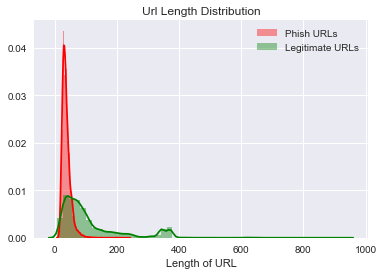

In [19]:
# Data Visualization, Distribution according to length of URL
sns.set(style = 'darkgrid')
sns.distplot(featureSet[featureSet['label'] == 0.0]['len(url)'], color='red', label = 'Phish URLs')
sns.distplot(featureSet[featureSet['label'] == 1.0]['len(url)'], color='green', label = 'Legitimate URLs')
plt.title('Url Length Distribution')
plt.legend(loc = 'upper right')
plt.xlabel('Length of URL')

plt.show()

In [20]:
# Preparing for model training
featureSet = sklearn.utils.shuffle(featureSet)
# axis = 1 means drop by column
X = featureSet.drop(['label'], axis = 1).values # without label
Y = featureSet['label'].values # label
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,75.0,0.0,0.0,0.0,0.0,1.0,0.0,22.0,0.0,...,22.0,8.0,7.0,106.0,0.0,2.0,13.0,8.0,5.0,93.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,3.0,2.0,1.0,21.0,0.0,1.0,15.0,2.0,0.0,6.0
2,0.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,...,10.0,2.0,2.0,72.0,0.0,1.0,13.0,2.0,1.0,59.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,...,8.0,4.0,3.0,58.0,0.0,2.0,20.0,4.0,1.0,38.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,4.0,2.0,2.0,36.0,0.0,2.0,20.0,2.0,0.0,16.0


In [21]:
pd.DataFrame(Y).head()

,0
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0


In [22]:
model = {"Decision Tree" : tree.DecisionTreeClassifier(max_depth = 10),
         "Random Forest" : ensembleLearning.RandomForestClassifier(n_estimators = 50),
         "Adaboost" : ensembleLearning.AdaBoostClassifier(n_estimators = 50),
         "Gradient Boosting" : ensembleLearning.GradientBoostingClassifier(n_estimators = 50),
         "GNB" : GaussianNB(),
         "Logistic Regression" : LogisticRegression()
}

Decision Tree : 0.902 
Got 6314 out of 7000
f1 = 0.90
precision = 0.95
recall = 0.85
accuracy = 0.90


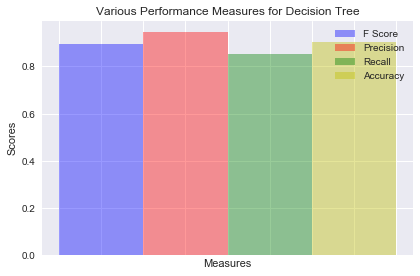

Random Forest : 0.912285714286 
Got 6386 out of 7000
f1 = 0.91
precision = 0.93
recall = 0.89
accuracy = 0.91


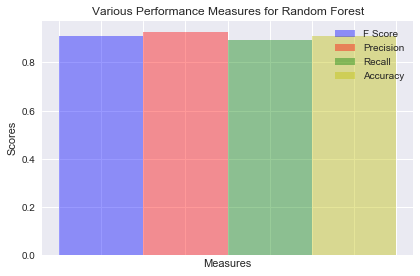

Adaboost : 0.894428571429 
Got 6261 out of 7000
f1 = 0.89
precision = 0.93
recall = 0.85
accuracy = 0.89


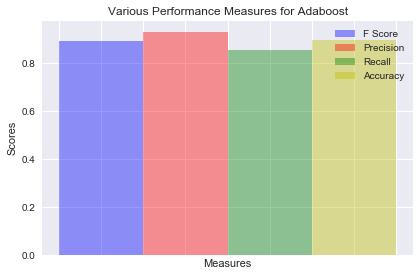

Gradient Boosting : 0.895857142857 
Got 6271 out of 7000
f1 = 0.89
precision = 0.92
recall = 0.87
accuracy = 0.90


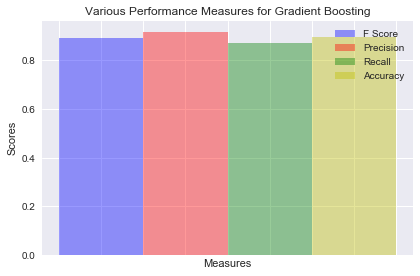

GNB : 0.817142857143 
Got 5720 out of 7000
f1 = 0.78
precision = 0.96
recall = 0.67
accuracy = 0.82


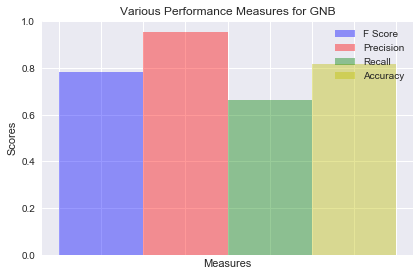

Logistic Regression : 0.847714285714 
Got 5934 out of 7000
f1 = 0.84
precision = 0.90
recall = 0.78
accuracy = 0.85


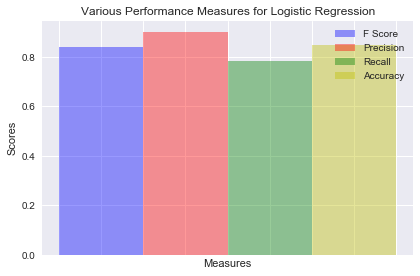

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size = (1 - cut_ratio))
results = {}

for algo in model:
    clf = model[algo]
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score
    
    Y_predict = clf.predict(X_test)
    get_f1_score(Y_test, Y_predict, "Various Performance Measures for %s"%algo)

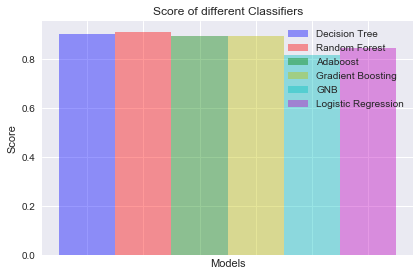

Best Classifier : Random Forest
False positive rate : 2.029477 %
False negative rate : 4.340297 %
             precision    recall  f1-score   support

        0.0       0.96      0.98      0.97     17098
        1.0       0.98      0.96      0.97     17902

avg / total       0.97      0.97      0.97     35000



In [24]:
show_scores_bar(results, model)

winner = max(results, key = results.get)
print("Best Classifier : " + winner)

clf = model[winner]
res = clf.predict(X)
con_matrix = confusion_matrix(Y, res)

print("False positive rate : %f %%" % ((con_matrix[0][1] / float(sum(con_matrix[0])))*100))
print('False negative rate : %f %%' % ((con_matrix[1][0] / float(sum(con_matrix[1]))*100)))

print(classification_report(Y, res))

In [25]:
# url = dfRequired[['domain']].iloc[from_index:to_index, 0]
# url.head()

In [26]:
# label = dfRequired[['label']].iloc[from_index:to_index, 0]
# label.head()

In [27]:
# print("Total Count : " + str(len(label)))

In [28]:
# features_and_labels = make_feature_vector(from_index, url, label)
# df_features_and_labels = pd.DataFrame(features_and_labels)
# df_features_and_labels.head()

In [29]:
# len(features_and_labels)

In [30]:
# features_and_labels = np.array(features_and_labels)
# random.shuffle(features_and_labels)

# cut = int(len(features_and_labels) * cut_ratio)
# XY_train = features_and_labels[:cut]
# XY_test = features_and_labels[cut:]

# df_features_and_labels = pd.DataFrame(features_and_labels)
# df_features_and_labels.head()

In [31]:
# X_train, Y_train = make_np_array_XY(XY_train)
# X_test, Y_test = make_np_array_XY(XY_test)
# pd.DataFrame(X_train).head()

In [32]:
# pd.DataFrame(Y_train).head()

In [33]:
# len(X_train)

In [34]:
# len(Y_train)

In [35]:
# SVM SVC Classifier with Linear Kernel
#C = 1.0  # SVM regularization parameter
#svc = svm.SVC(kernel = 'linear', C = C).fit(X_train, Y_train)

In [36]:
# Predicted Label
#Y_predict = svc.predict(X_test)
#(pd.DataFrame(Y_predict)).head()

In [37]:
# Actual Label
#(pd.DataFrame(Y_test)).head()

In [38]:
#print("Prev Winner Score : " + str(clf.score(X_test, Y_test)))
#print("score : " + str(svc.score(X_test, Y_test)))
#get_f1_score(Y_test, Y_predict, "Various Performance Measures for SVM SVC Classifier with Linear Kernel")

In [39]:
# Hyper Parameter tuning for SVM

# param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
# clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
# clf = clf.fit(X_train, Y_train)
# print("Best estimator found by grid search:")
# print(clf.best_estimator_)
# from sklearn.metrics import make_scorer, roc_auc_score
# auc = make_scorer(roc_auc_score)

# mdl = svm.SVC(probability = True, random_state = 1)

# rand_list = {"C": [0.01, 0.1, 1, 10, 100],
#             'kernel': ['linear']}
              
# rand_search = RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 5, n_jobs = 4, cv = 3, random_state = 2017, scoring = auc) 
# rand_search.fit(X_train, Y_train) 
# rand_search.cv_results_